In [181]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target
from lib.ext.baycon.common.ScoreCalculator import ScoreCalculator
from lib.score_calculator_kmeans import ScoreCalculatorKmeans

<Axes: >

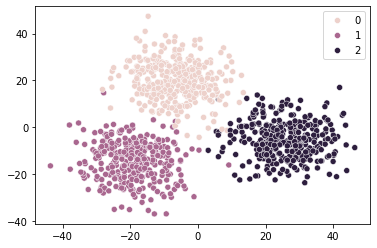

In [182]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [183]:
# model = RandomForestClassifier()
model = KMeans(n_clusters=3)
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

/home/jacob/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x12,x13,x14,x15,x16,x17,x18,x19,x20,label
0,10.406313,12.724350,-0.001170,-9.968949,15.201318,18.757330,-9.919282,-1.668630,-13.746649,1.397654,...,-3.928584,-0.528004,-22.583310,1.162686,-7.431764,-5.257503,2.384948,8.746468,4.324649,1.0
1,2.225755,-6.444151,6.118453,8.519935,-25.233191,-13.145253,-2.679357,9.173635,-4.965546,-2.710948,...,13.962399,-9.647196,0.699084,-3.821175,-3.135736,20.860835,17.556227,-10.701953,-11.662621,2.0
2,1.778758,5.317299,8.627705,5.049339,6.835201,-20.433112,-3.707592,18.444303,-20.338913,-20.738406,...,12.626192,-0.114460,-10.887584,-11.556019,-10.897458,-8.696875,3.227233,13.091300,-6.514685,1.0
3,-5.058212,9.129632,4.999189,7.793386,-4.213025,-14.208838,-6.838352,-14.255163,12.826505,9.425440,...,-7.162332,5.704911,-3.010290,4.124474,19.338497,-11.709396,-8.833234,-9.791955,-7.855519,0.0
4,19.523933,-8.901980,9.529263,29.438630,-22.948410,-6.388222,-6.415414,-10.639261,-1.841617,8.139007,...,-6.227071,14.727084,-1.066132,7.538024,5.094158,-6.544052,-4.266219,-10.239931,-22.461334,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-4.858639,-4.287770,13.592924,16.769207,-11.391313,-18.771087,1.707418,-0.891406,6.857236,0.318887,...,-19.472930,27.096800,-5.328006,-2.569917,6.855428,-11.481449,2.668063,0.222837,1.460354,0.0
996,8.741502,14.081452,-9.706502,-9.022972,19.526207,1.334459,12.530153,-1.242190,5.719426,-7.522878,...,0.896272,-2.207052,-4.213561,-6.197462,-1.413480,-2.395530,-0.684343,11.270831,-4.795903,1.0
997,4.289471,-3.981071,19.890838,1.984102,-14.078015,7.650229,-4.511179,-14.385152,24.355687,6.622240,...,-2.981581,-8.166675,-5.371982,10.846721,12.393304,2.465437,-1.175751,-9.928135,8.301484,0.0
998,-7.695227,-11.919228,15.540063,-12.843259,-13.616333,-18.792880,-3.721202,0.445090,17.216035,-16.354174,...,8.609733,6.494735,-13.464948,8.536051,10.540243,-3.216782,8.911928,8.022562,-9.849736,2.0


<Axes: >

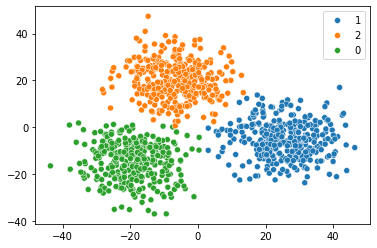

In [184]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [185]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]

    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))

    # Initialize ScoreCalculator Classification / Clustering
    initial_instance_f = initial_instance.astype(float)   # np operations need same type object to compute!
    if target.target_type() == Target.TYPE_CLASSIFICATION or target.target_type() == Target.TYPE_REGRESSION:
        score_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
    elif target.target_type() == Target.TYPE_CLUSTERING_KMEANS:
        point_pred = int(model.predict([X[initial_instance_index]])[0])
        target_cluster_center = model.cluster_centers_[point_pred]
        
        target_cluster_indices = np.where(y == initial_prediction)

        min_target_cluster_distance = np.min([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        
        base_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        score_calculator = ScoreCalculatorKmeans(initial_instance, initial_prediction, target, data_analyzer, base_calculator, min_target_cluster_distance, max_target_cluster_distance, target_cluster_center)

    counterfactuals, _ranker = baycon.run(initial_instance_f, initial_prediction, target, data_analyzer, model, score_calculator)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))

    return counterfactuals, predictions, initial_instance, initial_prediction #, data_analyzer, ranker, model


In [186]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
# t = Target(target_type="classification", target_feature="label", target_value=0)
t = Target(target_type="clustering_kmeans", target_feature="label", target_value=0)

cf, _predictions, _initial_instance, _initial_prediction = execute(df, model, t, point_idx)

Point prediction:  1 <class 'int'>
--- Executing... Initial Instance: 0 Target: 0 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---


IndexError: invalid index to scalar variable.

<Axes: >

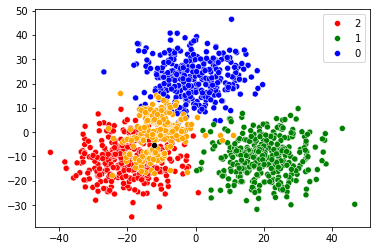

In [ ]:
embed_cf = pca.transform(cf)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')